In [22]:
#TODO
#Write variations of pneumonia
#Try with cancer
#doublecheck the model
#...

Importimine

In [23]:
import zipfile
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

Kopsupõletikku tuvastamine

In [24]:

# Path to the ZIP file
zip_path = "archive.zip"
extract_path = "extracted_photos"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, "r") as zip_file:
    zip_file.extractall(extract_path)


zip_path = "archive (1).zip"
# Extract the ZIP file
with zipfile.ZipFile(zip_path, "r") as zip_file:
    zip_file.extractall(extract_path)

zip_path = "archive (2).zip"
# Extract the ZIP file
with zipfile.ZipFile(zip_path, "r") as zip_file:
    zip_file.extractall(extract_path)



In [25]:
import shutil

def create_symlinks(src_dirs, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for src_dir in src_dirs:
        for root, dirs, files in os.walk(src_dir):
            for file in files:
                src_file = os.path.join(root, file)
                relative_path = os.path.relpath(root, src_dir)
                dest_file_dir = os.path.join(dest_dir, relative_path)
                if not os.path.exists(dest_file_dir):
                    os.makedirs(dest_file_dir)
                dest_file = os.path.join(dest_file_dir, file)
                # Copy the file to the destination folder, preserving the directory structure
                if not os.path.exists(dest_file):
                    shutil.copy2(src_file, dest_file)
# Paths to the individual datasets
src_train_dirs = [
    'extracted_photos/chest_xray/chest_xray/train',
    'extracted_photos/Data/train',
    'extracted_photos/Train',
    'extracted_photos/chest_xray/train'
]

src_test_dirs = [
    'extracted_photos/chest_xray/chest_xray/test',
    'extracted_photos/Data/test',
    'extracted_photos/Test',
    'extracted_photos/chest_xray/test'
]

# Path to the combined dataset
combined_train_dir = 'combined_dataset/train'
combined_test_dir = 'combined_dataset/test'

# Create symlinks for train and test data
create_symlinks(src_train_dirs, combined_train_dir)
create_symlinks(src_test_dirs, combined_test_dir)

# ImageDataGenerators for training and testing
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create the train and test generators from the combined directory
train_generator = train_datagen.flow_from_directory(
    combined_train_dir,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    combined_test_dir,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical'
)


Found 11125 images belonging to 4 classes.
Found 2070 images belonging to 4 classes.


In [26]:
# Load pre-trained VGG16 model and add custom layers on top
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

# Evaluate the fine-tuned model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Fine-tuned test accuracy: {test_acc}")

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 1,049,220 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50


c:\Users\artur\anaconda3\envs\VisualStudioEnv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 431s 5s/step - accuracy: 0.7361 - loss: 0.7484 - val_accuracy: 0.8633 - val_loss: 0.3250
Epoch 2/50
 1/86 ━━━━━━━━━━━━━━━━━━━━ 4:11 3s/step - accuracy: 0.8359 - loss: 0.3826

c:\Users\artur\anaconda3\envs\VisualStudioEnv\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8359 - loss: 0.3826 - val_accuracy: 0.9091 - val_loss: 0.1990
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 375s 4s/step - accuracy: 0.8805 - loss: 0.3202 - val_accuracy: 0.9033 - val_loss: 0.2501
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7891 - loss: 0.4858 - val_accuracy: 0.9091 - val_loss: 0.3192
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.8891 - loss: 0.2873 - val_accuracy: 0.8901 - val_loss: 0.2583
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8906 - loss: 0.3089 - val_accuracy: 0.8636 - val_loss: 0.2585
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 355s 4s/step - accuracy: 0.8995 - loss: 0.2661 - val_accuracy: 0.8989 - val_loss: 0.2312
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9297 - loss: 0.2630 - val_accuracy: 1.0000 - val_loss: 0.0726
Epoch 9/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 371s 4s/step - accuracy: 0.9171 - loss: 0.2349 - val_accuracy: 0.9028 - val_loss: 0.2347

In [27]:
# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(150, 150)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale to 0-1 range
    return img_array

# Function to make predictions on new images
def predict_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)
    return prediction



['combined_dataset/test/TUBERCULOSIS/Tuberculosis-1.png', 'combined_dataset/test/PNEUMONIA/person1_virus_6.jpeg', 'combined_dataset/test/NORMAL/IM-0001-0001.jpeg', 'combined_dataset/test/COVID19/COVID19(461).jpg', 'random Lung pics/covid.jpg', 'random Lung pics/covidorpneumo.png', 'random Lung pics/pnevmo2.jpg', 'random Lung pics/тубер.png', 'random Lung pics/тубер2.jpg', 'random Lung pics/туберЧёрныйБумер.jpg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
The image combined_dataset/test/TUBERCULOSIS/Tuberculosis-1.png is predicted to be TUBERCULOSIS with a probability of 1.0000


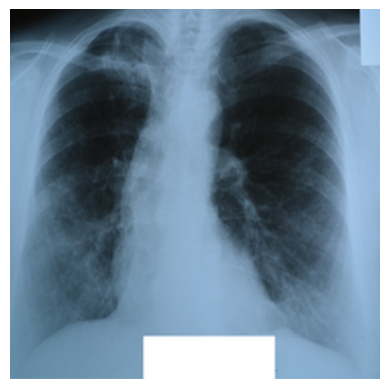

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
The image combined_dataset/test/PNEUMONIA/person1_virus_6.jpeg is predicted to be PNEUMONIA with a probability of 1.0000


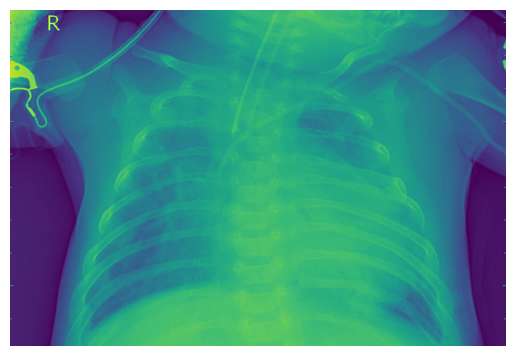

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
The image combined_dataset/test/NORMAL/IM-0001-0001.jpeg is predicted to be NORMAL with a probability of 1.0000


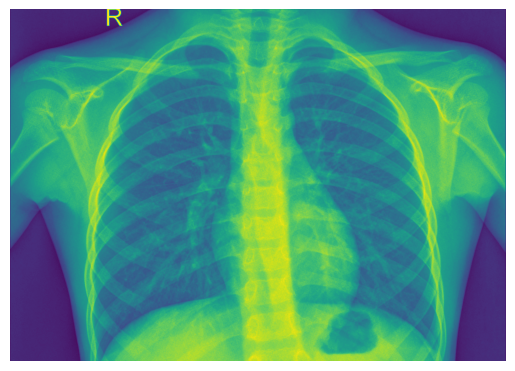

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
The image combined_dataset/test/COVID19/COVID19(461).jpg is predicted to be COVID19 with a probability of 1.0000


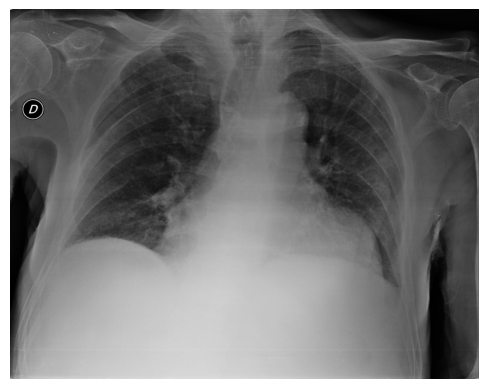

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
The image random Lung pics/covid.jpg is predicted to be COVID19 with a probability of 0.9607


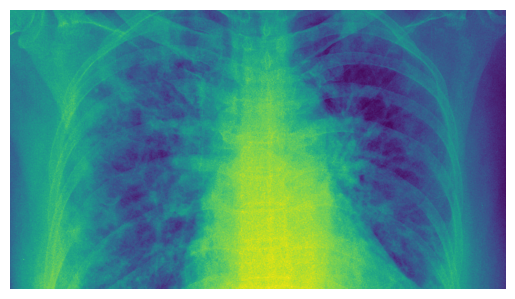

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
The image random Lung pics/covidorpneumo.png is predicted to be COVID19 with a probability of 1.0000


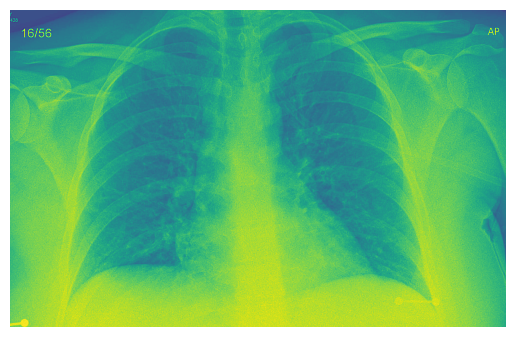

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
The image random Lung pics/pnevmo2.jpg is predicted to be COVID19 with a probability of 0.5968


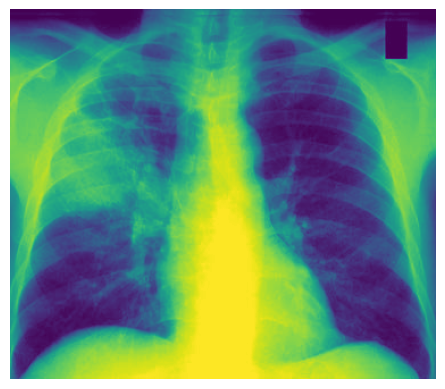

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
The image random Lung pics/тубер.png is predicted to be COVID19 with a probability of 0.9419


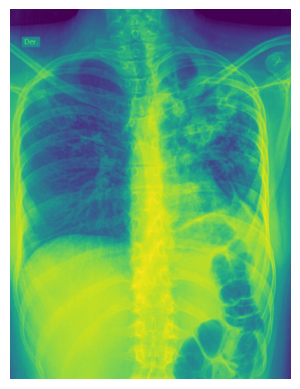

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
The image random Lung pics/тубер2.jpg is predicted to be COVID19 with a probability of 0.9961


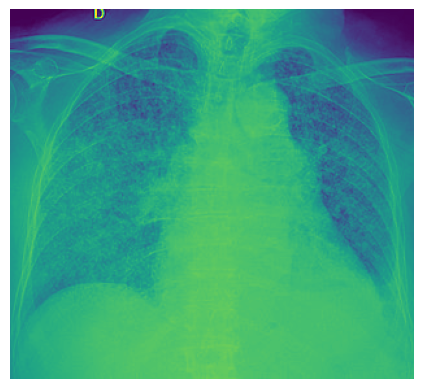

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
The image random Lung pics/туберЧёрныйБумер.jpg is predicted to be COVID19 with a probability of 0.9933


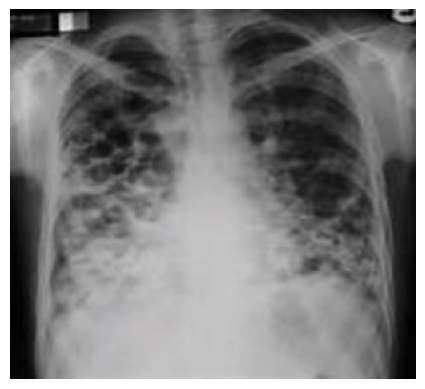

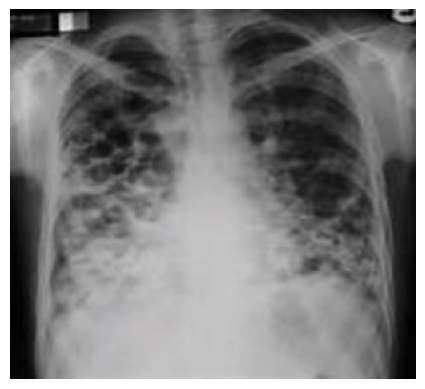

In [30]:
# Example of predicting on new images
# Если я папку не смогу загрузить, сделайте дир random Lung pics и можете туда загружать рандом картинки с инета

new_images = ["combined_dataset/test/TUBERCULOSIS/Tuberculosis-1.png",
              "combined_dataset/test/PNEUMONIA/person1_virus_6.jpeg",
              "combined_dataset/test/NORMAL/IM-0001-0001.jpeg",
              "combined_dataset/test/COVID19/COVID19(461).jpg"]  # Replace with your new image paths

new_images = new_images + ["random Lung pics/" + a for a in os.listdir("random Lung pics")] 
print(new_images)

for img_path in new_images:
    img = Image.open(img_path)

    prediction = predict_image(img_path)
    class_index = np.argmax(prediction[0])
    class_label = list(train_generator.class_indices.keys())[class_index]
    print(f"The image {img_path} is predicted to be {class_label} with a probability of {prediction[0][class_index]:.4f}")

    plt.imshow(img)
    plt.axis('off')
    display(plt.gcf())